### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU

### Exploratory Data Analysis (EDA)

In [ ]:
### load the dataset

df = pd.read_csv('monthly_milk_production.csv', index_col='Date', parse_dates=True)
df.index.freq = 'MS'

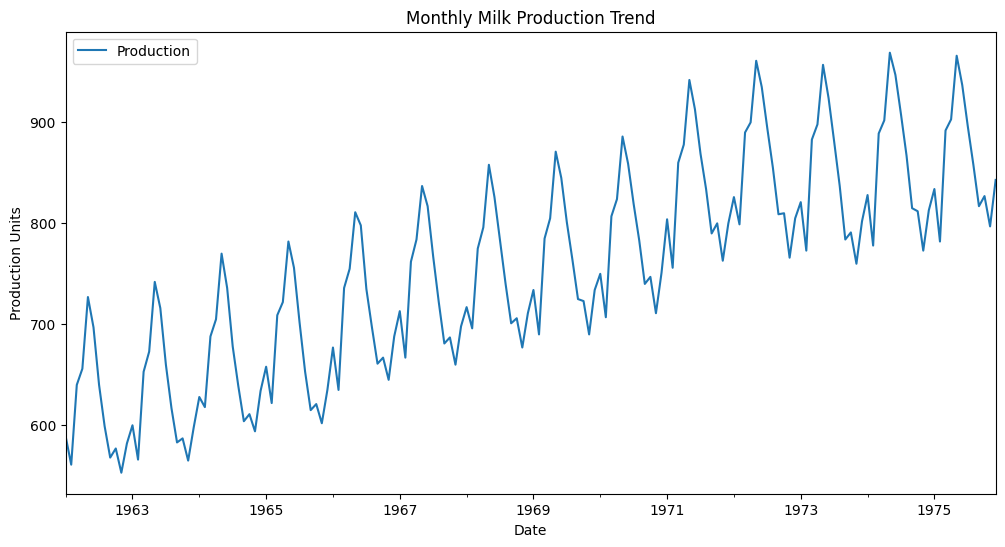

In [ ]:
# Visualize trends and seasonality [cite: 17, 18]

df.plot(figsize=(12,6), title="Monthly Milk Production Trend")
plt.ylabel("Production Units")
plt.show()

In [ ]:
# Scale data for neural networks

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

### Data Preparation for Deep Learning

In [ ]:
# Split into Training and Testing (Last 12 months for testing) [cite: 23, 37]

train_size = len(scaled_data) - 12
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [ ]:
# Create input sequences (Window size of 12 months) [cite: 22, 24, 30]

def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

In [ ]:
window_size = 12
X_train, y_train = create_sequences(train_data, window_size)

In [ ]:
def build_model(model_type):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(100, activation='relu', input_shape=(window_size, 1)))
    elif model_type == 'LSTM':
        model.add(LSTM(100, activation='relu', input_shape=(window_size, 1)))
    elif model_type == 'GRU':
        model.add(GRU(100, activation='relu', input_shape=(window_size, 1)))

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

### Model Evaluation

In [ ]:
models = ['RNN', 'LSTM', 'GRU']
results = {}

In [ ]:
for m_type in models:
    print(f"Training {m_type}...")
    model = build_model(m_type)
    model.fit(X_train, y_train, epochs=100, verbose=0, batch_size=1)

    # Forecasting the test period
    test_predictions = []
    first_eval_batch = train_data[-window_size:]
    current_batch = first_eval_batch.reshape((1, window_size, 1))

    for i in range(len(test_data)):
        current_pred = model.predict(current_batch, verbose=0)[0]
        test_predictions.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

    # Inverse scaling
    true_predictions = scaler.inverse_transform(test_predictions)
    results[m_type] = true_predictions

Training RNN...
Training LSTM...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training GRU...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Evaluation & Comparison

In [ ]:
actual = df.iloc[-12:]['Production'].values

In [ ]:
print("\nModel Performance Metrics:")
for m_type in models:
    rmse = np.sqrt(mean_squared_error(actual, results[m_type]))
    mae = mean_absolute_error(actual, results[m_type])
    print(f"{m_type} -> RMSE: {rmse:.2f}, MAE: {mae:.2f}")


Model Performance Metrics:
RNN -> RMSE: 49.16, MAE: 46.48
LSTM -> RMSE: 17.85, MAE: 15.13
GRU -> RMSE: 25.89, MAE: 22.79


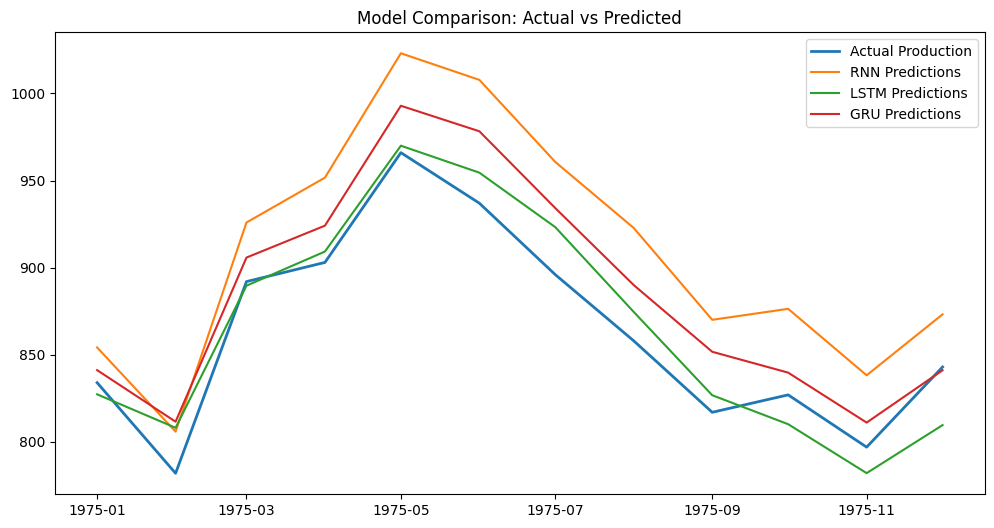

In [ ]:
# Visualize Comparisons [cite: 36, 38]
plt.figure(figsize=(12,6))
plt.plot(df.index[-12:], actual, label='Actual Production', linewidth=2)
for m_type in models:
    plt.plot(df.index[-12:], results[m_type], label=f'{m_type} Predictions')
plt.legend()
plt.title("Model Comparison: Actual vs Predicted")
plt.show()

### Business Insights

Consistent Long-Term Growth: The business demonstrated steady upward momentum, with total production growing by approximately 43% over the 14-year period.

Predictable Seasonal Peaks: Production consistently reaches its annual peak in May, indicating a recurring period of high yield that likely requires maximum processing and logistics capacity.

Cyclical Supply Lows: The lowest production levels occur every November, identifying a predictable annual supply crunch where inventory management or alternative sourcing becomes critical.

Significant Operational Variance: There is a roughly 26% production gap between the peak month (May) and the lowest month (November), highlighting the need for a flexible workforce and scalable storage solutions.

High Stability and Resilience: Despite minor year-over-year fluctuations (such as a slight dip in 1973), the overall trend remains robust, suggesting a stable market and reliable production infrastructure.